In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
# from model import Brain
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import pandas as pd
from itertools import accumulate
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)
from lib.sde.grn3 import GRNMain3
from lib.sde.mutate import mutate_grn2
from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L

In [3]:
HISTORY = defaultdict(dict)
HALL_OF_FAME = []

In [4]:
_count = -1
def provide_id():
    global _count
    _count += 1
    return _count

In [5]:
REF = O(
    stats=pd.read_csv("output/results/setup_basic/export/ref_basic2.csv"),  # ref is a mean
    # fmetric=setup_ref_fmetric("output/results/setup_basic/export/ref_fmetric_tristate.csv"),
)

In [6]:
def individual_generator(id_=-1):
    return Solution(GRNMain3(5, 0, 0), id_=id_)

In [7]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        for i in range(1):
            mutate_grn2(self.grn)
        # here force values
        self.grn.set_mutable()
        self.grn._params[4, :] = 1
        self.grn._params[5, :] = 0
        self.grn.compile()

In [8]:
# def score_bb_size(bb, ref, *args, **kwargs):
#     return score_both_size_norm(bb.stats, ref.stats, *args, **kwargs, norm=2.0)

In [9]:
def score_bb_size(bb, ref, *args, **kwargs):
    """Returns the max score of the subbrains
    It will later be translated to fitness (1 / score)"""
    score = 1e-9
    for i in range(3):
        new_score = (
            score_stats_norm(bb.stats, ref.stats, col_stats=f"tag_prog{i}",
                             col_ref="progenitor_pop_size", norm=2.0, *args, **kwargs)
            + score_stats_norm(bb.stats, ref.stats, col_stats=f"tag_whole{i}",
                             col_ref="whole_pop_size", norm=2.0, *args, **kwargs)
        )
        score = max(score, new_score)
    return score

def score_bb_size_old(bb, ref, *args, **kwargs):
    return (
        score_stats_norm(bb.stats, ref.stats, col_stats=f"progenitor_pop_size",
                         col_ref="progenitor_pop_size", norm=2.0, *args, **kwargs)
        + score_stats_norm(bb.stats, ref.stats, col_stats=f"whole_pop_size",
                         col_ref="whole_pop_size", norm=2.0, *args, **kwargs)
    )

In [10]:
def setup_tag(cp):
    indexes = list(cp.base_population.keys())
    shuffle(indexes)
    splits = np.array_split(indexes, 3)
    for i, ls in enumerate(splits):
        for idx in ls:
            cp.base_population[idx].tag["subbrain"] = i

In [11]:
def get_bb(prun, grn):
    ccls = factories["grn3"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        tag_prog0=TagNumberCallback(TargetPopulation.progenitor, "subbrain", 0, neg=True),
        tag_prog1=TagNumberCallback(TargetPopulation.progenitor, "subbrain", 1, neg=True),
        tag_prog2=TagNumberCallback(TargetPopulation.progenitor, "subbrain", 2, neg=True),
        tag_whole0=TagNumberCallback(TargetPopulation.whole, "subbrain", 0, neg=True),
        tag_whole1=TagNumberCallback(TargetPopulation.whole, "subbrain", 1, neg=True),
        tag_whole2=TagNumberCallback(TargetPopulation.whole, "subbrain", 2, neg=True),
    )
    bb = BrainModel(time_step=0.5, verbose=False, start_population=prun.size, max_pop_size=2e3,
            cell_cls=ccls, end_time=prun.end_time, start_time=50, silent=True, opti=True,
              run_tissue=False, monitor_callbacks=callbacks, tag_func=setup_tag)
    return bb

In [12]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [13]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        # score_step = score_both_size(bb.stats, prun.ref, max_step=step.end_time, min_step=previous_time)
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

def score_multistep(prun, stats, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    # first step
    for i, step in enumerate(steps):
        # score_step = score_both_size(bb.stats, prun.ref, max_step=step.end_time, min_step=previous_time)
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        print(f"Score for step {i} is {score_step}")
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness
        previous_time = step.end_time
        
    return total_fitness

In [14]:
def mean_sd_fitness(prun, grn, run=3):
    fitnesses = [fitness_multistep(prun, grn) for i in range(run)]
    return np.mean(fitnesses), np.std(fitnesses)

In [15]:
def multi_fitness(*args):
    fitnesses = [fitness_multistep(*args) for i in range(3)]
    scores = [x[0] for x in fitnesses]
    return fitnesses[scores.index(min(scores))]

In [16]:
def do_init(prun):
    return individual_generator(provide_id())

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id())
    
    if prun.normalize:
        pop_fit = normalize_fitness_values(pop_fit)
    return weighted_selection_one(pop, pop_fit, individual_generator, new_fitness=0.5, id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [17]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 4
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_steps_stabilize = [
    ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="3", start_time=56, end_time=59, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="4", start_time=59, end_time=62, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="5", start_time=62, end_time=65, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="6", start_time=65, end_time=68, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="7", start_time=68, end_time=71, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="8", start_time=71, end_time=74, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="9", start_time=74, end_time=77, score_func=score_bb_size, min_fitness=0.5),
]

example_steps = [
    ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size_old),
    ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size_old),
    ObjectiveStep(name="3", start_time=56, end_time=59, score_func=score_bb_size_old),
    ObjectiveStep(name="4", start_time=59, end_time=62, score_func=score_bb_size_old),
    ObjectiveStep(name="5", start_time=62, end_time=65, score_func=score_bb_size_old),
    ObjectiveStep(name="6", start_time=65, end_time=68, score_func=score_bb_size_old),
    ObjectiveStep(name="7", start_time=68, end_time=71, score_func=score_bb_size_old),
    ObjectiveStep(name="8", start_time=71, end_time=74, score_func=score_bb_size_old),
    ObjectiveStep(name="9", start_time=74, end_time=77, score_func=score_bb_size_old),
]

class ParamRun(O):
    pop_size = 10
    n_gen = 10
    current_gen = 0
    end_time = 83
    ref = REF
    min_pop = 20
    max_pop = 50

def get_prun(size=5, normalize=False, stabilize=False):
    prun = ParamRun()
    prun.size = size
    prun.normalize = normalize
    prun.steps = example_steps_stabilize if stabilize else example_steps
    return prun

In [18]:
def main(prun):
    prun.history = defaultdict(dict)
    # exporter = Exporter()
    best = 0
    sol = do_init(prun)
    pop = [sol]
    for generation in range(prun.n_gen * prun.pop_size):
        # args.generation = generation
        # objective.new_trial()
        fit, stats = do_fitness(prun, sol)
        sol.fit = fit
        sol.stats = stats
        
        # history
        # print(f"Fitness = {fit}", end="\t\t")
        if generation % 100 == 0:
            print(f"Step {generation}")
        if fit > best:
            print(f"++ Best {fit} for generation {generation}")
            best = fit
            
        monitor = sol
        prun.history[generation] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        # TODO get the stats associated with the best scores
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
    print("OVER")
    return best

In [19]:
def get_score_parametrized(size=5, normalize=False, stabilize=False, name=None):
    args = get_prun(size, normalize, stabilize)
    args.name = name
    main(args)
    p1 = L(args.history.values()).fit
    idx = p1.index(max(p1))
    sol = args.history[idx]
    scores = [fitness_multistep(args, sol.grn, args.steps)[0] for i in range(10)]
    return np.mean(scores), np.std(scores), max(p1)

In [20]:
from itertools import product
import jf.models.stringmodel as sm

In [21]:
model = sm.StringModel("expstab_s{size}_n{norm}_stab{stab}_i{i}")
keys = ("size", "norm", "stab", "i")
gen = product([3, 5, 7], [True, False], [True, False], range(5))

In [ ]:
# main loop
exporter = Exporter(name="exp_stability")
for i, sample in enumerate(gen):
    name = model.fill(**dict(zip(keys, sample)))
    print(name, sample)
    if name in exporter.list():
        continue
    res = get_score_parametrized(*sample)
    exporter(res, name)

Exporting at output/exp_stability
expstab_s3_nTrue_stabTrue_i0 (3, True, True, 0)
Step 0
++ Best 0.007802428045840235 for generation 0
++ Best 0.11424390116263752 for generation 1
++ Best 0.1237114574346721 for generation 2
++ Best 0.34911173204651813 for generation 18
++ Best 0.3744929156992088 for generation 28
++ Best 0.41439184972732046 for generation 54
++ Best 0.46439614336344437 for generation 59
OVER
Step 1 passed !
expstab_s3_nTrue_stabTrue_i1 (3, True, True, 1)
Step 0
++ Best 0.10441946141025651 for generation 0
++ Best 0.16854249055919 for generation 5
++ Best 0.19984122832115847 for generation 7
++ Best 0.4497318827002907 for generation 12
++ Best 0.4694311809256541 for generation 60
Step 2 passed !
++ Best 1.2036127893084745 for generation 74
OVER
expstab_s3_nTrue_stabTrue_i2 (3, True, True, 2)
Step 0
++ Best 0.0907228057412207 for generation 0
++ Best 0.20754551519511974 for generation 1
++ Best 0.3195315262158325 for generation 7
++ Best 0.4443611459785686 for generation

In [25]:
print(1)

1


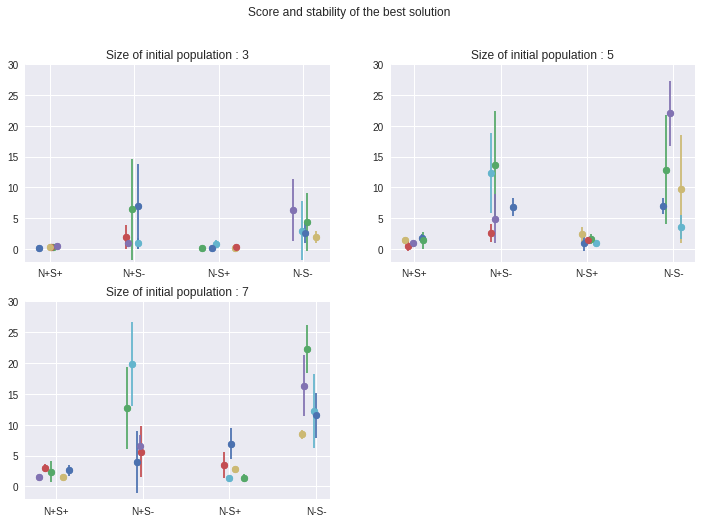

In [40]:
plt.figure(figsize=(12, 8))
plt.suptitle("Score and stability of the best solution")
for i, size in enumerate([3, 5, 7]):
    plt.subplot(2, 2, i + 1)
    plt.title(f"Size of initial population : {size}")
    plt.xticks([0, 1, 2, 3], ["N+S+", "N+S-", "N-S+", "N-S-"])
    plt.ylim((-2, 30))
    for j, (norm, stab) in enumerate(product([True, False], [True, False])):
        for x in exporter.list():
            if not model.match_param(x, dict(size=size, norm=norm, stab=stab)):
                continue
            res = exporter.load(x)
            d = j + np.random.normal(0, 0.1)
            plt.scatter(d, [res[0]])
            plt.errorbar(d, [res[0]], yerr=[res[1]], fmt="o")

In [48]:
df = pd.DataFrame([{**model.extract(x), **{k: v for k, v in zip(["mean", "sd", "best"], exporter.load(x))}} for x in exporter.list()])

In [66]:
filt1 = (df["size"] == "5") & (df["norm"] == "True") & (df["stab"] == "False")
filt2 = (df["size"] == "5") & (df["norm"] == "False") & (df["stab"] == "False")
df[filt1]["mean"].mean(), df[filt2]["mean"].mean()

(8.110191378264377, 11.019278543790955)

In [67]:
filt1 = (df["size"] == "3") & (df["norm"] == "True") & (df["stab"] == "False")
filt2 = (df["size"] == "3") & (df["norm"] == "False") & (df["stab"] == "False")
df[filt1]["mean"].mean(), df[filt2]["mean"].mean()

(3.4535249983360217, 3.665829764195556)

In [68]:
filt1 = (df["size"] == "7") & (df["norm"] == "True") & (df["stab"] == "False")
filt2 = (df["size"] == "7") & (df["norm"] == "False") & (df["stab"] == "False")
df[filt1]["mean"].mean(), df[filt2]["mean"].mean()

(9.736623672411197, 14.164926823550228)

In [69]:
filt1 = (df["size"] == "7") & (df["stab"] == "False")
filt2 = (df["size"] == "5") & (df["stab"] == "False")
df[filt1]["mean"].mean(), df[filt2]["mean"].mean()

(11.950775247980712, 9.564734961027666)

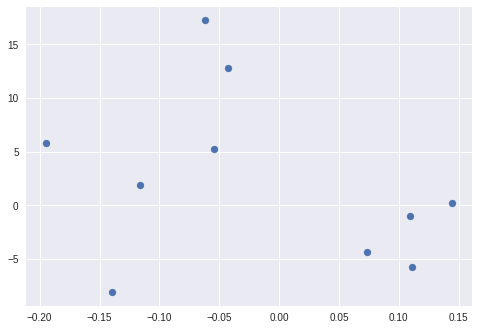

In [81]:
# paired statistic
df1 = df[(df["size"] == "7") & (df["stab"] == "False")].set_index(["norm", "i"]).copy()
df2 = df[(df["size"] == "5") & (df["stab"] == "False")].set_index(["norm", "i"]).copy()

ls_val = []
for i, row in df1.iterrows():
    ls_val.append(df1.loc[i]["mean"] - df2.loc[i]["mean"])

plt.scatter(np.random.normal(0, 0.1, len(ls_val)), ls_val)

In [83]:
np.mean(ls_val), np.mean(ls_val) - np.std(ls_val) / np.sqrt(len(ls_val))

-0.03594690843719839

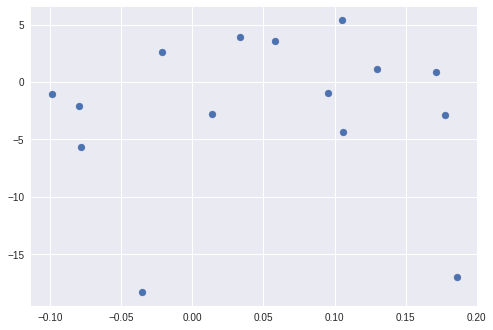

In [84]:
# paired statistic
df1 = df[(df["norm"] == "True") & (df["stab"] == "False")].set_index(["size", "i"]).copy()
df2 = df[(df["norm"] == "False") & (df["stab"] == "False")].set_index(["size", "i"]).copy()

ls_val = []
for i, row in df1.iterrows():
    ls_val.append(df1.loc[i]["mean"] - df2.loc[i]["mean"])

plt.scatter(np.random.normal(0, 0.1, len(ls_val)), ls_val)

In [86]:
np.mean(ls_val), np.mean(ls_val) + np.std(ls_val) / np.sqrt(len(ls_val))

(-2.5165650275083817, -0.7935091173740474)